In [1]:
import numpy as np
import sympy
from collections import OrderedDict

sympy.init_printing(print_builtin=True)

In [2]:
import qsymm

# Graphene

We use the Hamiltonian generator to reproduce the spinless nearest neighbour tight binding Hamiltonian for graphene.

The generators of the symmetry group are time-reversal symmetry, sublattice (or chiral) symmetry, and threefold rotation symmetry.

In [3]:
# Time reversal
TR = qsymm.PointGroupElement(sympy.eye(2), True, False, np.eye(2))

# Chiral symmetry
C = qsymm.PointGroupElement(sympy.eye(2), False, True, np.array([[1, 0], [0, -1]]))

# Atom A rotates into A, B into B.
sphi = 2*sympy.pi/3
RC3 = sympy.Matrix([[sympy.cos(sphi), -sympy.sin(sphi)],
                  [sympy.sin(sphi), sympy.cos(sphi)]])
C3 = qsymm.PointGroupElement(RC3, False, False, np.eye(2))

symmetries = [C, TR, C3]

There are two carbon atoms per unit cell (A and B) with one orbital each. The lattice is triangular, and only includes hoppings between nearest neighbour atoms. This restricts hoppings to only those between atoms of different types, such that each atom couples to three neighbouring atoms. Using the symmetrization strategy to generate the Hamiltonian, it is sufficient to specify hoppings to one such neighbour along with the symmetry generators, and we take the vector $(1, 0)$ to connect this neighbouring pair of atoms.

In [42]:
norbs = OrderedDict({'A': 1, 'B': 1})  # A and B atom per unit cell, one orbital each
hopping_vectors = [('A', 'B', [0, 1])] # Hopping between neighbouring A and B atoms

Generate the Hamiltonian.

In [43]:
family = qsymm.bloch_family(hopping_vectors, symmetries, norbs)

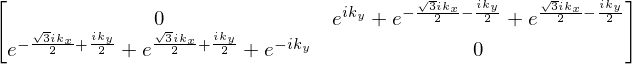

In [44]:
qsymm.display_family(family)

Scale the bond length in terms of the graphene lattice constant, and have the function return a list of BlochModel objects.

In [48]:
hopping_vectors = [('A', 'B', [0, 1/np.sqrt(3)])] # Hopping between neighbouring A and B atoms

In [49]:
family = qsymm.bloch_family(hopping_vectors, symmetries, norbs, bloch_model=True)

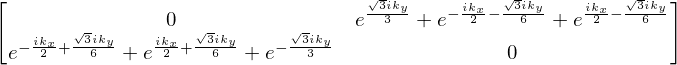

In [50]:
qsymm.display_family(family)

# Three-orbital tight binding model for monolayer MX$_2$

We use the Hamiltonian generator to reproduce the tight binding model for monolayer MX$_2$ published in Phys. Rev. B 88, 085433 (2013).

The generators of the symmetry group of the tight binding model are time reversal symmetry, mirror symmetry and threefold rotation symmetry.

In [51]:
# Time reversal
TR = qsymm.PointGroupElement(sympy.eye(2), True, False, np.eye(3))

# Mirror symmetry 
Mx = qsymm.PointGroupElement(sympy.Matrix([[-1, 0], [0, 1]]), False, False, np.diag([1, -1, 1]))

# Threefold rotation on d_z^2, d_xy, d_x^2-y^2 states.
C3U = np.array([[1, 0, 0],
                 [0, -0.5, -np.sqrt(3)/2],
                 [0, np.sqrt(3)/2, -0.5]])
# Could also use the predefined representation of rotations on d-orbitals
Ld = qsymm.groups.L_matrices(3, 2)
C3U2 = qsymm.groups.spin_rotation(2 * np.pi * np.array([0, 0, 1/3]), Ld)
# Restrict to d_z^2, d_xy, d_x^2-y^2 states
mask = np.array([1, 2 ,0])
C3U2 = C3U2[mask][:, mask]
assert np.allclose(C3U, C3U2)

# The spatial part of the symmetry must be provided as a symbolic matrix
# or an integer array
sphi = 2*sympy.pi/3
C3R = sympy.Matrix([[sympy.cos(sphi), -sympy.sin(sphi)],
                     [sympy.sin(sphi), sympy.cos(sphi)]])
C3 = qsymm.PointGroupElement(C3R, False, False, C3U)

symmetries = [TR, Mx, C3]

Next, we specify the hoppings to include. The tight binding model has a triangular lattice, three orbitals per M atom, and nearest neighbour hopping.

In [52]:
# One site per unit cell (M atom), with three orbitals
norbs = OrderedDict({'a': 3})

Each atom has six nearest neighbour atoms at a distance of one primitive lattice vector. Since we use the symmetrization strategy to generate the Hamiltonian, it is sufficient to specify a hopping to one nearest neighbour atom along with the symmetry generators. We take the primitive vector connecting the pair of atoms to be $(1, 0)$.

In [65]:
# Hopping to a neighbouring atom one primitive lattice vector away
hopping_vectors = [('a', 'a', [1, 0])]

Generate the tight binding Hamiltonian.

In [66]:
family = qsymm.bloch_family(hopping_vectors, symmetries, norbs)

The Hamiltonian family should include 8 linearly independent components, including the onsite terms.

In [67]:
len(family)

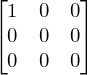

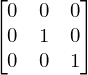

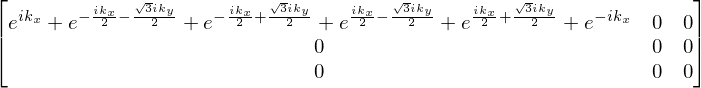

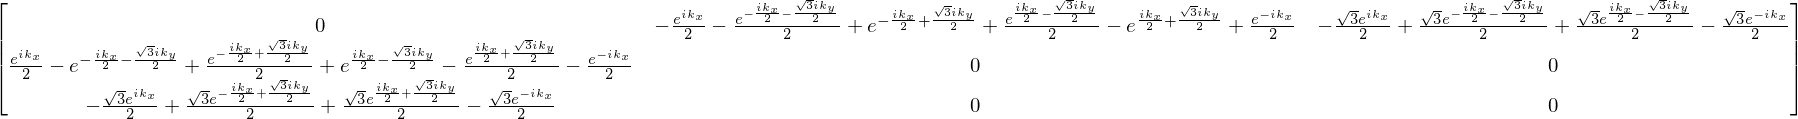

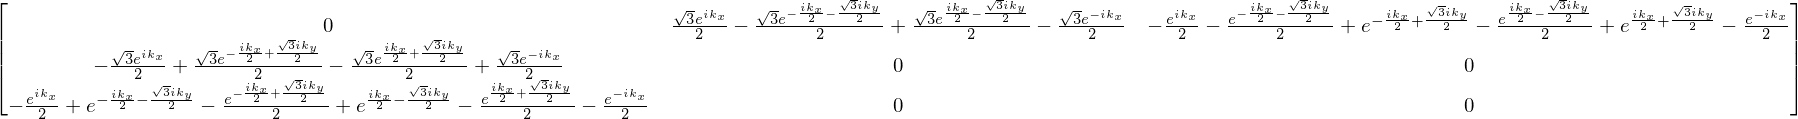

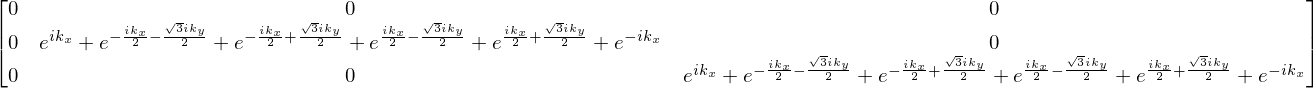

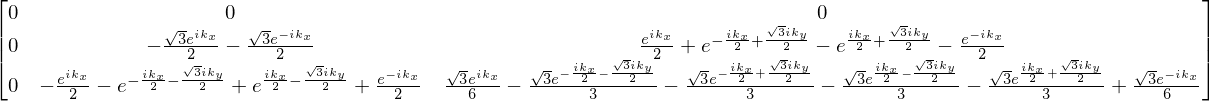

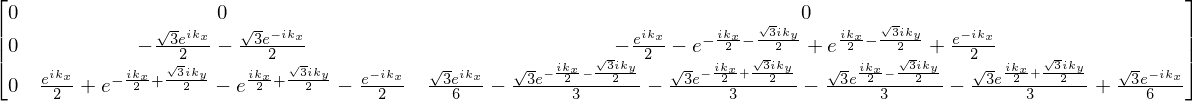

In [68]:
qsymm.display_family(family, nsimplify=True)

# 4-site model for monolayer WTe$_2$

We use the Hamiltonian generator to reproduce the tight binding model for monolayer WTe$_2$ published in Phys. Rev. X 6, 041069 (2016).

The generators of the symmetry group of the tight binding model are time reversal symmetry, glide reflection and inversion symmetry.

In [69]:
# Define 4 sites with one orbital each
sites = ['Ad', 'Ap', 'Bd', 'Bp']
norbs = OrderedDict({site: 1 for site in sites})

# Define symbolic coordinates for orbitals
rAp = qsymm.sympify('[x_Ap, y_Ap]')
rAd = qsymm.sympify('[x_Ad, y_Ad]')
rBp = qsymm.sympify('[x_Bp, y_Bp]')
rBd = qsymm.sympify('[x_Bd, y_Bd]')

# Define hoppings to include
hopping_vectors = [('Bd', 'Bd', np.array([1, 0])),
                   ('Ap', 'Ap', np.array([1, 0])),
                   ('Bd', 'Ap', rAp - rBd),
                   ('Ap', 'Bp', rBp - rAp),
                   ('Ad', 'Bd', rBd - rAd),                   
                  ]

In [70]:
# Inversion
perm_inv = {'Ad': 'Bd', 'Ap': 'Bp', 'Bd': 'Ad', 'Bp': 'Ap'}
onsite_inv = {site: (1 if site in ['Ad', 'Bd'] else -1) * np.eye(1) for site in sites}
inversion = qsymm.groups.symmetry_from_permutation(-np.eye(2), perm_inv, norbs, onsite_inv)

# Glide
perm_glide = {site: site for site in sites}
onsite_glide = {site: (1 if site in ['Ad', 'Bd'] else -1) * np.eye(1) for site in sites}
glide = qsymm.groups.symmetry_from_permutation(np.array([[-1, 0],[0, 1]]), perm_glide, norbs, onsite_glide)

# TR
time_reversal = qsymm.PointGroupElement(np.eye(2), True, False, np.eye(4))

gens = {glide, inversion, time_reversal}
sg = qsymm.groups.generate_group(gens)
len(sg)

Generate the tight binding Hamiltonian.

In [71]:
family = qsymm.bloch_family(hopping_vectors, gens, norbs=norbs)
print(len(family), [len(fam) for fam in family])

7 [1, 1, 4, 4, 2, 2, 4]


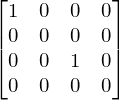

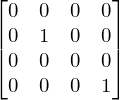

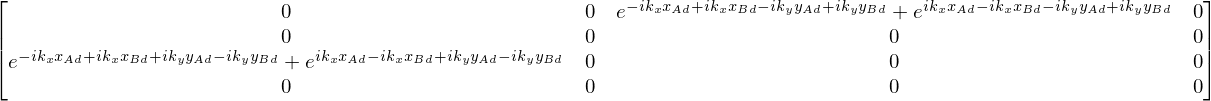

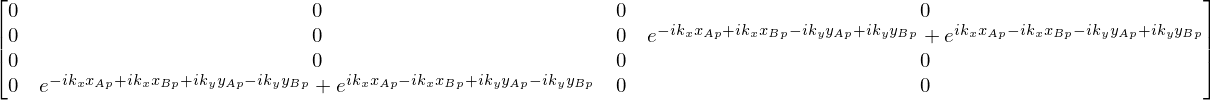

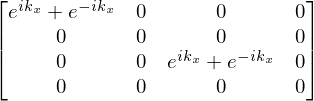

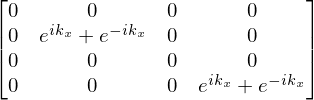

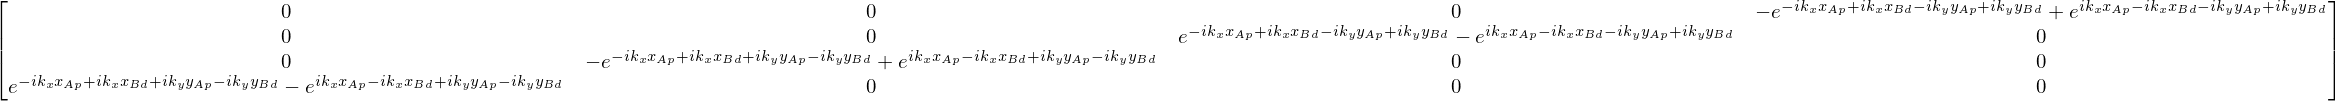

In [72]:
qsymm.display_family(family)

# Square lattice with 4 sites in the UC

Make model with square lattice that has 4 sites in the unit cell related by 4-fold rotation. Sites have spin-1/2 and we add time reversal and particle-hole symmetry.

In [73]:
hopping_vectors = [('a', 'b', np.array([1, 0])),
                   ('b', 'a', np.array([1, 0])),
                   ('c', 'd', np.array([1, 0])),
                   ('d', 'c', np.array([1, 0])),
                   ('a', 'c', np.array([0, 1])),
                   ('c', 'a', np.array([0, 1])),
                   ('b', 'd', np.array([0, 1])),
                   ('d', 'b', np.array([0, 1])),                  
                  ]

# Define spin-1/2 operators
S = qsymm.groups.spin_matrices(1/2)
# Define real space rotation generators in 2D
L = qsymm.groups.L_matrices(d=2)

sites = ['a', 'b', 'c', 'd']
norbs = OrderedDict({site: 2 for site in sites})

perm_C4 = {'a': 'b', 'b': 'd', 'd': 'c', 'c': 'a'}
onsite_C4 = {site: qsymm.groups.spin_rotation(2*np.pi * np.array([0, 0, 1/4]), S) for site in sites}
C4 = qsymm.groups.symmetry_from_permutation(
                qsymm.groups.spin_rotation(2*np.pi * np.array([1/4]), L, roundint=True), 
                perm_C4, norbs, onsite_C4)

# Fermionic TR
time_reversal = qsymm.PointGroupElement(np.eye(2), True, False, 
                np.kron(np.eye(4), qsymm.groups.spin_rotation(2*np.pi * np.array([0, 1/2, 0]), S)))

# define strange PH symmetry
particle_hole = qsymm.PointGroupElement(np.eye(2), True, True, np.eye(8))

gens = {C4, time_reversal, particle_hole}

sg = qsymm.groups.generate_group(gens)
len(sg)

2 [4, 4]


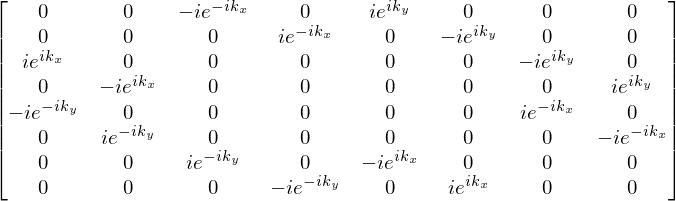

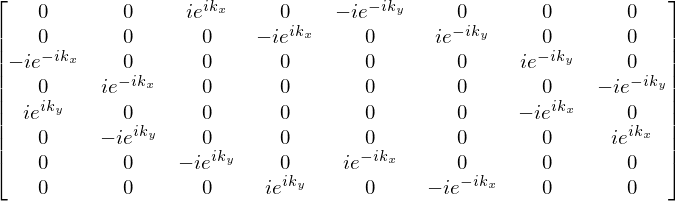

In [74]:
family = qsymm.bloch_family(hopping_vectors, gens, norbs=norbs)
print(len(family), [len(fam) for fam in family])
qsymm.display_family(family)